# First-Order and Second-Order Methods

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.math import sigmoid
from tensorflow.keras.optimizers import SGD
from tensorflow.nn import softmax
%tensorflow_version 2.x

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

## Convexity of the problem

Let's unroll loss function:

$$
	loss = \mathcal{L}(w) = \frac{-1}{M}[y^\top \log(\sigma(Xw)) + (1 - y^\top) \log(1 - \sigma(Xw))] = \frac{1}{M} \sum_{i=1}^{M} -y_i \log(\sigma(w^\top x_i)) - (1 - y_i) \log(1 - \sigma(w^\top x_i)),
$$


where the sigmoid function $\sigma: \mathbb{R}^n \to \mathbb{R}_{++}$ is defined as:

$$\sigma(\mathbf{z}) = \frac{1}{1 + e^{-\mathbf{z}}}$$

First, we prove that functions
$f(\mathbf{z}) = -\log(\sigma(\mathbf{z}))$
and
$g(\mathbf{z}) = -\log(1 - \sigma(\mathbf{z}))$
are convex.

**Proof.**

$$
	\nabla_\mathbf{z} \, f(\mathbf{z}) = \frac{-e^{-\mathbf{z}}}{1+e^{-\mathbf{z}}} = \frac{1}{1+e^{-\mathbf{z}}} - 1 = \sigma(\mathbf{z}) - 1
	\Rightarrow
	\nabla^2_\mathbf{z} \, f(\mathbf{z}) = \sigma(\mathbf{z})(1 - \sigma(\mathbf{z})) > 0
$$

Therefore, $f$ is a convex function.

$$
    g(\mathbf{z}) = -\log(\frac{e^{-\mathbf{z}}}{1+e^{-\mathbf{z}}}) = \log(1+e^{-\mathbf{z}}) + \mathbf{z} = f(\mathbf{z}) + \mathbf{z}
$$

Since sum of two convex functions is a convex function, $g(\mathbf{z})$ is convex.

Moreover, we know that composition of a convex function with an affine function is a convex function. So $-\log(\sigma(w^\top x_i))$ and $-\log(1 - \sigma(w^\top x_i))$ are convex functions in $w$. Because $-y_i \log(\sigma(w^\top x_i))$ and $- (1 - y_i) \log(1 - \sigma(w^\top x_i))$ are linear transformations of convex functions, so they are also convex functions. Since the sum of convex functions is a convex function, $\mathcal{L}(w)$ is convex.

## Model Definition

In [2]:
class Model():
    def __init__(self, n_features = 2, out_dim = 1):
        self.n_features = n_features
        self.out_dim = out_dim
        self.w = tf.Variable(tf.zeros(n_features), dtype = tf.float32)

    def logits(self, X, coef = 1):
        return coef * tf.linalg.matvec(X.astype(np.float32), self.w)

    def predict(self, X, coef = 1):
        return sigmoid(self.logits(X, coef))
    
    def loss(self, X, y, coef = 1):
        y_hat = tf.clip_by_value(self.predict(X, coef), 1e-9, 1.)
        return -tf.reduce_mean(y * tf.math.log(y_hat) + (1 - y) * tf.math.log(1 - y_hat))

    def gradients(self, X, y, coef = 1):
        with tf.GradientTape() as tape:
            loss = self.loss(X, y, coef)
        return tape.gradient(loss, self.w)

    def hessians(self, X, y, coef = 1):
        with tf.GradientTape(persistent=True) as tape:
            grads = self.gradients(X, y, coef)
            grad_grads = [tape.gradient(g, self.w) for g in grads]

        hess_rows = [gg[tf.newaxis, ...] for gg in grad_grads]
        return tf.concat(hess_rows, axis=0)

    def Fisher(self, X, y, coef = 1):
        F = []
        with tf.GradientTape(persistent=True) as tape:
            for i in range(len(X)):
                y_hat = tf.clip_by_value(model.predict(X[i:i+1], coef), 1e-9, 1.)
                log_likelihood = y[i:i+1] * tf.math.log(y_hat) + (1 - y[i:i+1]) * tf.math.log(1 - y_hat)
                g_log_likelihood = tape.gradient(log_likelihood, model.w).numpy()
                F.append(np.matmul(g_log_likelihood.reshape(-1, 1), g_log_likelihood.reshape(1, -1)))
        return sum(F) / len(F)

    def natural_gradients(self, X, y, coef = 1):
        grads = self.gradients(X, y, coef)
        fish = self.Fisher(X, y, coef)
        inv_fish = tf.linalg.inv(fish)
        return tf.linalg.matvec(inv_fish, grads)

    def gradient_descent(self, X, y, optimizer, coef = 1):
        grads = self.gradients(X, y, coef)
        optimizer.apply_gradients(zip([grads], [self.w]))

    def Newton_method(self, X, y, optimizer, coef = 1):
        grads = self.gradients(X, y, coef)
        hess = self.hessians(X, y, coef)
        inv_hess = tf.linalg.inv(hess)
        delta = tf.linalg.matvec(inv_hess, grads)
        optimizer.apply_gradients(zip([delta], [self.w]))

    def natural_gradient_descent(self, X, y, optimizer, coef = 1):
        nat_grads = self.natural_gradients(X, y, coef)
        optimizer.apply_gradients(zip([nat_grads], [self.w]))

## Initialization

In [3]:
M = 200
n_features = 2
n_train = 150

In [4]:
X = np.concatenate((np.random.randn(M//2, n_features)-1, 1+np.random.randn(M//2, n_features)))
y = np.concatenate((np.zeros(M//2, dtype = np.int32), np.ones(M//2, dtype = np.int32)))
p = np.random.permutation(M)
train_idx, test_idx = p[:n_train], p[n_train:]
X_train, X_test = X[train_idx,:], X[test_idx,:]
y_train, y_test = y[train_idx], y[test_idx]
model = Model()

## Data Visualization

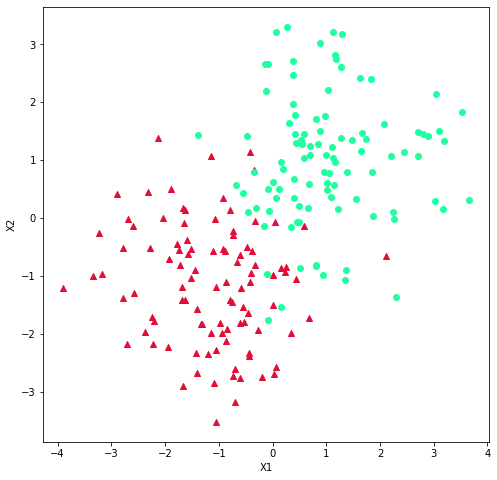

In [5]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:M//2,0], X[:M//2,1], marker='^', c='#e30e38')
plt.scatter(X[M//2:,0], X[M//2:,1], marker='o', c='#1fffa2')
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

## Loss Surface Visualization

In [6]:
W1 = np.arange(-2, 2, 0.05)
W2 = np.arange(-2, 2, 0.05)
W1, W2 = np.meshgrid(W1, W2)
L = np.zeros(W1.shape)

In [7]:
for i in range(len(W1)):
    for j in range(len(W2)):
        model.w.assign([W1[0, i], W2[j, 0]])
        L[i, j] = model.loss(X, y)

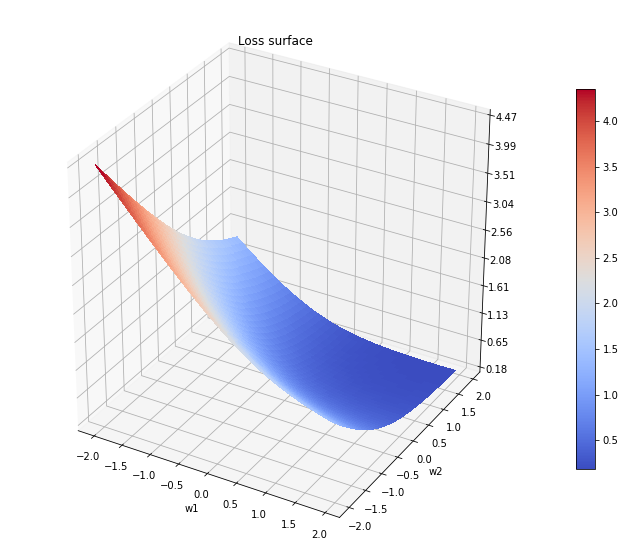

In [8]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(W1, W2, L, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.7)
plt.title("Loss surface")
plt.xlabel('w1')
plt.ylabel('w2')
plt.show()

## Gradient Descent

In [9]:
model.w.assign([0, 0])
optimizer = SGD(0.2)
gd_train_loss = [model.loss(X_train, y_train)]
gd_test_loss = [model.loss(X_test, y_test)]

In [10]:
for t in range(5):
    model.gradient_descent(X_train, y_train, optimizer)
    gd_train_loss.append(model.loss(X_train, y_train))
    gd_test_loss.append(model.loss(X_test, y_test))
    print(model.w.numpy())

[0.11355962 0.10807808]
[0.20752437 0.1966616 ]
[0.2864585  0.27024034]
[0.35409963 0.3324812 ]
[0.41317874 0.38607827]


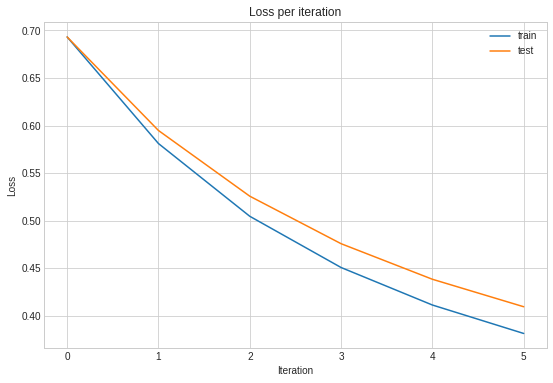

In [11]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(9, 6))
plt.title("Loss per iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(gd_train_loss, label='train')
plt.plot(gd_test_loss, label='test')
plt.legend()
plt.show()

## Newton Method

In [12]:
model.w.assign([0, 0])
optimizer = SGD(1)
nt_train_loss = [model.loss(X_train, y_train)]
nt_test_loss = [model.loss(X_test, y_test)]

In [13]:
for t in range(5):
    model.Newton_method(X_train, y_train, optimizer)
    nt_train_loss.append(model.loss(X_train, y_train))
    nt_test_loss.append(model.loss(X_test, y_test))
    print(model.w.numpy())

[0.6751735 0.5646712]
[1.2470112  0.88538384]
[1.8929702 1.1858484]
[2.4634967 1.4452342]
[2.7576294 1.5839043]


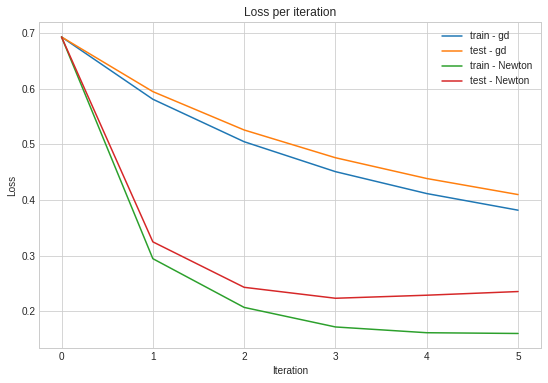

In [14]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(9, 6))
plt.title("Loss per iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(gd_train_loss, label='train - gd')
plt.plot(gd_test_loss, label='test - gd')
plt.plot(nt_train_loss, label='train - Newton')
plt.plot(nt_test_loss, label='test - Newton')
plt.legend()
plt.show()

## Natural Gradient Descent

When we update our model in its gradients direction, the new model's distribution might not be similar to the previous one. So in natural gradient descent, we consider all combinations of parameters that result in a new model, a constant distance away from the old model, and take step in the distribution space:

$$
\delta^* = \mathop{\text{arg min}}_{\delta \text{ s.t. } \text{KL}[p_w \Vert p_{w + \delta}] = c} \mathcal{L} (w + \delta),
$$
where $c$ is a constant, and KL-divergence measures the distance of two distributions.


Fisher information Matrix is the Hessian of KL divergence between two distributions $p(X|w)$ and $p(X|w')$ with respect to $w'$ and calculated at $w$:

$$
\text{F}_w = \nabla_{w'}^2 \, \text{KL}[p(X \vert w) \, \Vert \, p(X \vert w')]
$$

$\text{F}_w$ provides a local measure of distance. Intuitively, it gives the change in the distribution for a small change in parameters. So assuming $\delta \rightarrow 0$, we can approximate the KL-divergence by its second order Taylor series:

$$
\text{KL}[p(X \vert w) \, \Vert \, p(X \vert w + \delta)] \approx \frac{1}{2} \delta^\top \text{F}_w \delta
$$


Thus we could express $\mathop{\text{arg min}}_{\delta \text{ s.t. } \text{KL}[p_w \Vert p_{w + \delta}] = c} \mathcal{L} (w + \delta)$ as a Lagrangian, where the KL-divergence is approximated by $\frac{1}{2} \delta^\top \text{F}_w \delta$. By setting Lagrangian's derivative wrt. $\delta$ to zero, we obtain

$$
\delta = -\frac{1}{\lambda} \text{F}_w^{-1} \nabla_w \mathcal{L}(w),
$$

where $\lambda$ is a dual variable. We fold the scalar $\frac{1}{\lambda}$ into the learning rate to get the natural gradient decent formula:

$$
\tilde{\nabla}_w \mathcal{L}(w) = \text{F}_w^{-1} \nabla_w \mathcal{L}(w)
$$

In [15]:
model.w.assign([0, 0])
optimizer = SGD(0.2)
ng_train_loss = [model.loss(X_train, y_train)]
ng_test_loss = [model.loss(X_test, y_test)]

In [16]:
for t in range(5):
    model.natural_gradient_descent(X_train, y_train, optimizer)
    ng_train_loss.append(model.loss(X_train, y_train))
    ng_test_loss.append(model.loss(X_test, y_test))
    print(model.w.numpy())

[0.13503471 0.11293427]
[0.31936637 0.2510137 ]
[0.6049223  0.43484277]
[1.0953804  0.70332915]
[1.8137999 1.0452518]


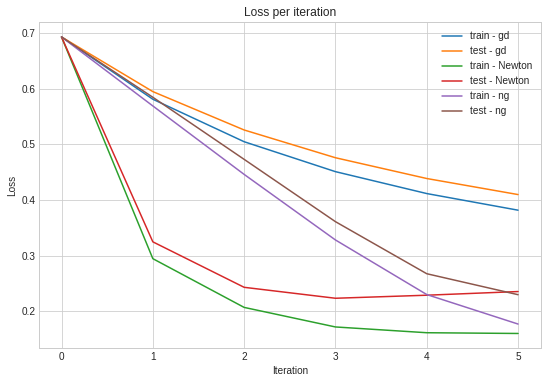

In [17]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(9, 6))
plt.title("Loss per iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(gd_train_loss, label='train - gd')
plt.plot(gd_test_loss, label='test - gd')
plt.plot(nt_train_loss, label='train - Newton')
plt.plot(nt_test_loss, label='test - Newton')
plt.plot(ng_train_loss, label='train - ng')
plt.plot(ng_test_loss, label='test - ng')
plt.legend()
plt.show()

## Linear Transformed Coordinates

In [18]:
W1 = np.arange(-2, 2, 0.05)
W2 = np.arange(-2, 2, 0.05)
W1, W2 = np.meshgrid(W1, W2)
L = np.zeros(W1.shape)

In [19]:
for i in range(len(W1)):
    for j in range(len(W2)):
        model.w.assign([W1[0, i], W2[j, 0]])
        L[i, j] = model.loss(X, y, 0.01)

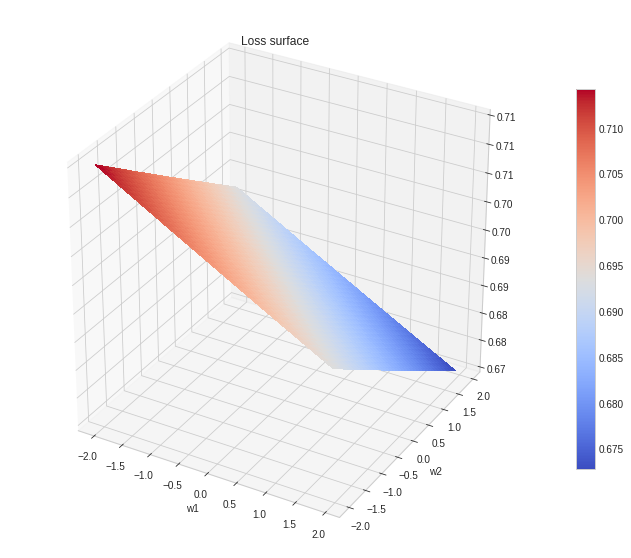

In [20]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(W1, W2, L, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.7)
plt.title("Loss surface")
plt.xlabel('w1')
plt.ylabel('w2')
plt.show()

## Gradient Descent

In [21]:
model.w.assign([0, 0])
optimizer = SGD(0.2)
gd_transformed_train_loss = [model.loss(X_train, y_train, 0.01)]
gd_transformed_test_loss = [model.loss(X_test, y_test, 0.01)]

In [22]:
for t in range(5):
    model.gradient_descent(X_train, y_train, optimizer, 0.01)
    gd_transformed_train_loss.append(model.loss(X_train, y_train, 0.01))
    gd_transformed_test_loss.append(model.loss(X_test, y_test, 0.01))
    print(model.w.numpy())

[0.0011356  0.00108078]
[0.00227117 0.00216154]
[0.00340673 0.00324228]
[0.00454227 0.004323  ]
[0.00567778 0.00540371]


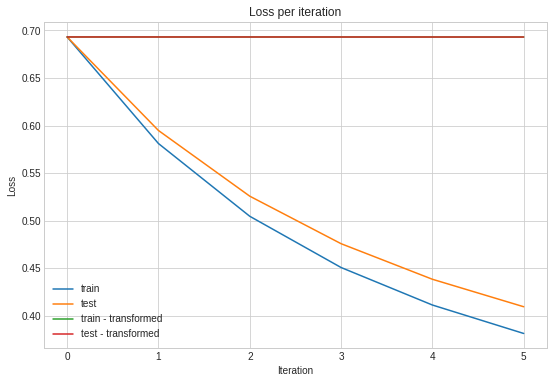

In [23]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(9, 6))
plt.title("Loss per iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(gd_train_loss, label='train')
plt.plot(gd_test_loss, label='test')
plt.plot(gd_transformed_train_loss, label='train - transformed')
plt.plot(gd_transformed_test_loss, label='test - transformed')
plt.legend()
plt.show()

## Newton Method

In [24]:
model.w.assign([0, 0])
optimizer = SGD(1)
nt_transformed_train_loss = [model.loss(X_train, y_train, 0.01)]
nt_transformed_test_loss = [model.loss(X_test, y_test, 0.01)]

In [25]:
for t in range(5):
    model.Newton_method(X_train, y_train, optimizer, 0.01)
    nt_transformed_train_loss.append(model.loss(X_train, y_train, 0.01))
    nt_transformed_test_loss.append(model.loss(X_test, y_test, 0.01))
    print(model.w.numpy())

[67.517365 56.46712 ]
[124.70111  88.5384 ]
[189.297   118.58485]
[246.34966 144.52342]
[275.76294 158.39043]


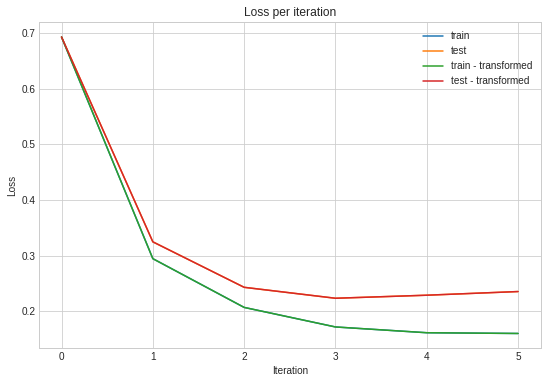

In [26]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(9, 6))
plt.title("Loss per iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(nt_train_loss, label='train')
plt.plot(nt_test_loss, label='test')
plt.plot(nt_transformed_train_loss, label='train - transformed')
plt.plot(nt_transformed_test_loss, label='test - transformed')
plt.legend()
plt.show()

## Natural Gradient Descent

In [27]:
model.w.assign([0, 0])
optimizer = SGD(0.2)
ng_transformed_train_loss = [model.loss(X_train, y_train, 0.01)]
ng_transformed_test_loss = [model.loss(X_test, y_test, 0.01)]

In [28]:
for t in range(5):
    model.natural_gradient_descent(X_train, y_train, optimizer, 0.01)
    ng_transformed_train_loss.append(model.loss(X_train, y_train, 0.01))
    ng_transformed_test_loss.append(model.loss(X_test, y_test, 0.01))
    print(model.w.numpy())

[13.503467 11.293429]
[31.936628 25.101374]
[60.492203 43.484287]
[109.538025  70.33294 ]
[181.38    104.52523]


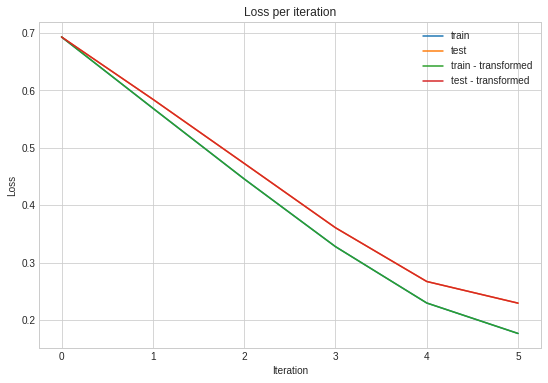

In [29]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(9, 6))
plt.title("Loss per iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(ng_train_loss, label='train')
plt.plot(ng_test_loss, label='test')
plt.plot(ng_transformed_train_loss, label='train - transformed')
plt.plot(ng_transformed_test_loss, label='test - transformed')
plt.legend()
plt.show()

## How the affine transformation affected?

The Newton method and natural gradient descent are affine invariant, implying that progress is independent of problem scaling. Thus, when the starting point is the same in both scenarios, the optimization path does not change. This is not true about gradient descent.

The gradient descent is not invariant under the affine transformation. When we scale coordinates by $0.01$, the gradients of the loss function is multiplied by $0.01$. Hence, in every point of the space, the step size is scaled by $0.01$ compared to that point in the untransformed coordinates. Consequently, the updates would cause smaller drops.

## Changes in the likelihood in Natural Gradient Descent

In [30]:
# Sort datapoints based on sum of coordinates
x_sorted, y_sorted = map(list, zip(*sorted(list(zip(X_train, y_train)), key=lambda tup: tup[0][0] + tup[0][1])))
x_sorted = np.array(x_sorted)
y_sorted = np.array(y_sorted)
x_axis = np.arange(n_train)

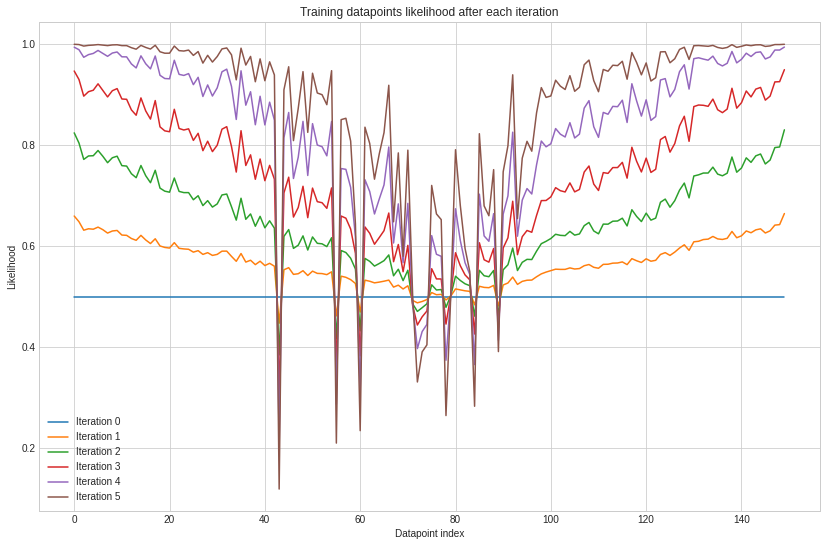

In [31]:
model.w.assign([0, 0])
preds = model.predict(x_sorted)
probs = (preds ** y_sorted) * ((1 - preds) ** (1 - y_sorted))

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(14, 9))
plt.title('Training datapoints likelihood after each iteration')
plt.ylabel('Likelihood')
plt.xlabel('Datapoint index')
plt.plot(x_axis, probs, label = 'Iteration {}'.format(0))

optimizer = SGD(0.2)

for t in range(5):
    model.natural_gradient_descent(X_train, y_train, optimizer)
    preds = model.predict(x_sorted)
    probs = (preds ** y_sorted) * ((1 - preds) ** (1 - y_sorted))
    plt.plot(x_axis, probs, label = 'Iteration {}'.format(t+1))

plt.legend()
plt.show()

## Conclusion

The standard gradient has no information about the loss function's curvature because it is a first-order optimization method. It also manages all the parameters equally by multiplying them by a learning rate. When we combine the Hessian or Fisher matrix with the gradient, we are scaling the parameter updates with the curvature of the function. Moreover, second-order techniques treat each parameter concerning its influence on the loss function. They can use a constant learning rate with the guarantee of convergence when we are close to optima. The normal gradient is not invariant to affine transformations; however, Newton's step direction is affine invariant, and natural gradient update has more invariance than simply affine invariance.

Nevertheless, second-order methods have a severe pitfall in real-world problems: the number of deep learning models' parameters is enormous, so the calculation of the Hessian and Fisher Matrix and their inverse becomes an intractable problem. Some heuristics (e.g., RMSProp) are developed to somehow benefit from second-order knowledge by approximating the Fisher/Hessian. For example, ADAM calculates the running average of the second moment of the gradient, which is Fisher's approximation with constraining it to be a diagonal matrix. Therefore, space and time complexity for computing, storing, or inverting is linear.

### Model Definition

In [ ]:
class MNIST_Model():
    def __init__(self, n_features = 784, n_classes = 10):
        self.n_features = n_features
        self.n_classes = n_classes
        self.W = tf.Variable(tf.ones([n_features, n_classes]), dtype = tf.float32)
        self.b = tf.Variable(tf.zeros([n_classes]))

    @tf.function
    def predict(self, X):
        return softmax(tf.matmul(X, self.W) + self.b)
    
    @tf.function
    def loss(self, X, y, gamma):
        y = tf.one_hot(y, depth=self.n_classes)
        y_hat = tf.clip_by_value(self.predict(X), 1e-9, 1.)
        cross_entropy = tf.reduce_mean(-tf.reduce_sum(y * tf.math.log(y_hat)))
        reg = tf.reduce_sum(tf.multiply(self.W, self.W)) + tf.reduce_sum(tf.multiply(self.b, self.b))
        return cross_entropy + gamma*reg / 2

    def accuracy(self, X, y):
        y_hat = self.predict(X)
        correct_prediction = tf.equal(tf.argmax(y_hat, 1), tf.cast(y, tf.int64))
        return tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) 

    @tf.function
    def gradients(self, X, y, gamma):
        with tf.GradientTape() as tape:
            loss = self.loss(X, y, gamma)
        return tape.gradient(loss, [self.W, self.b])

    def gradient_descent(self, X, y, gamma, optimizer):
        grads = self.gradients(X, y, gamma)
        optimizer.apply_gradients(zip(grads, [self.W, self.b]))
        return grads

    def SVRG(self, X, y, gamma, g_W, g_b, mu_W, mu_b, optimizer):
        grads_W, grads_b = self.gradients(X, y, gamma)
        delta_W = grads_W - g_W + mu_W
        delta_b = grads_b - g_b + mu_b
        optimizer.apply_gradients(zip([delta_W, delta_b], [self.W, self.b]))
        return delta_W, delta_b

### Problem 1

In [ ]:
def compute_variance(grads):
    gW, gb = map(list, zip(*grads))
    return tf.reduce_sum(tf.math.reduce_variance(gW, 0)) + tf.reduce_sum(tf.math.reduce_variance(gb, 0))

In [ ]:
def SGD_optimize(lambd, n_batch):   
    model = MNIST_Model()
    gamma = 1e-4
    optimizer = SGD(lambd)
    losses = [model.loss(X_train, y_train, gamma)]
    accs = [model.accuracy(X_test, y_test)]
    vars = []
    grads = []

    print('Step 0: loss=', losses[-1].numpy(), ', accuracy=', accs[-1].numpy())

    for t in range(100*M//n_batch):
        indices = np.random.choice(M, n_batch, replace = False)
        grad = model.gradient_descent(X_train[indices], y_train[indices], gamma, optimizer)
        grads.append(grad)

        if (t + 1) % (M/n_batch) == 0:
            losses.append(model.loss(X_train, y_train, gamma))
            accs.append(model.accuracy(X_test, y_test))
            vars.append(compute_variance(grads))
            grads = []

            print('Step {0}: loss= {1:0.3f}, accuracy= {2:0.3f}, variance= {3:0.3f}'.format(
                (t + 1) // (M//n_batch), losses[-1].numpy(), accs[-1].numpy(), vars[-1].numpy()))
    
    return losses, accs, vars

In [ ]:
SGD1_losses01, SGD1_accs01, SGD1_vars01, = SGD_optimize(0.01, 1)
SGD1_losses05, SGD1_accs05, SGD1_vars05, = SGD_optimize(0.05, 1)

Step 0: loss= 13815.89 , accuracy= 0.1
Step 1: loss= 2263.049, accuracy= 0.894, variance= 20.547
Step 2: loss= 2081.168, accuracy= 0.888, variance= 13.182
Step 3: loss= 1702.288, accuracy= 0.902, variance= 11.514
Step 4: loss= 1626.580, accuracy= 0.915, variance= 11.005
Step 5: loss= 1543.768, accuracy= 0.902, variance= 10.128
Step 6: loss= 1517.825, accuracy= 0.902, variance= 9.895
Step 7: loss= 1428.961, accuracy= 0.915, variance= 10.038
Step 8: loss= 1383.322, accuracy= 0.909, variance= 9.096
Step 9: loss= 1346.415, accuracy= 0.906, variance= 8.946
Step 10: loss= 1283.024, accuracy= 0.910, variance= 9.010
Step 11: loss= 1283.509, accuracy= 0.910, variance= 8.423
Step 12: loss= 1237.581, accuracy= 0.910, variance= 7.873
Step 13: loss= 1209.646, accuracy= 0.913, variance= 7.376
Step 14: loss= 1184.810, accuracy= 0.910, variance= 7.433
Step 15: loss= 1155.254, accuracy= 0.906, variance= 7.902
Step 16: loss= 1151.358, accuracy= 0.906, variance= 7.233
Step 17: loss= 1180.866, accuracy= 0

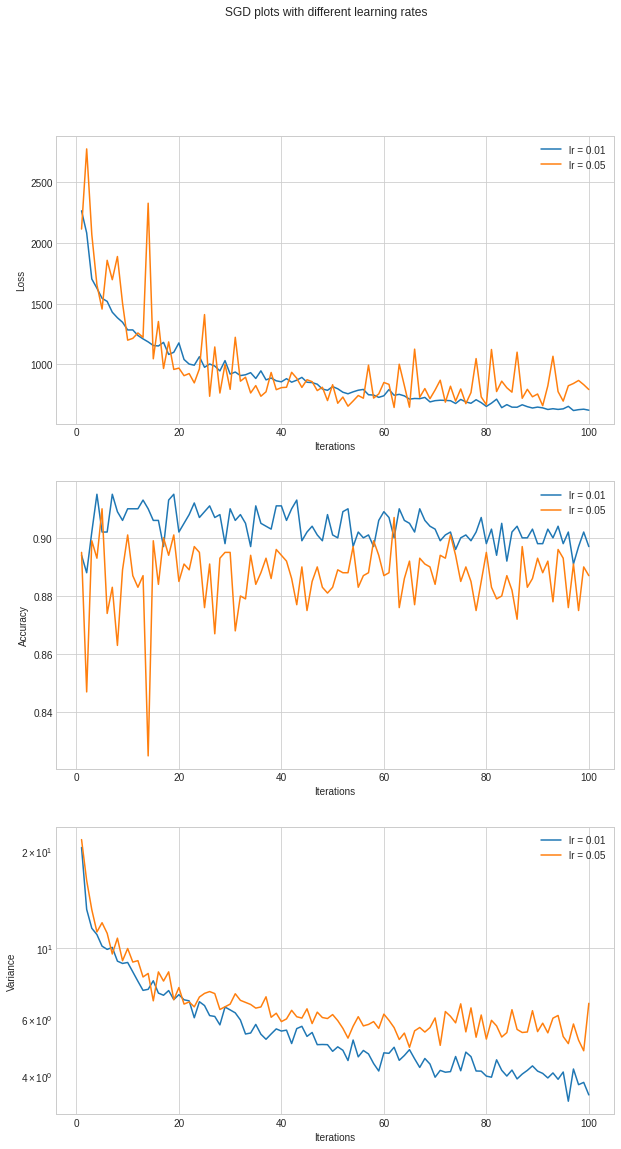

In [ ]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(3, figsize = (10, 18))
fig.suptitle('SGD plots with different learning rates')

axs[0].plot(range(1, 101), SGD1_losses01[1:], label='lr = 0.01')
axs[0].plot(range(1, 101), SGD1_losses05[1:], label='lr = 0.05')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Iterations')
axs[0].legend()

axs[1].plot(range(1, 101), SGD1_accs01[1:], label='lr = 0.01')
axs[1].plot(range(1, 101), SGD1_accs05[1:], label='lr = 0.05')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Iterations')
axs[1].legend()

axs[2].semilogy(range(1, 101), SGD1_vars01, label='lr = 0.01')
axs[2].semilogy(range(1, 101), SGD1_vars05, label='lr = 0.05')
axs[2].set_ylabel('Variance')
axs[2].set_xlabel('Iterations')
axs[2].legend()

### Problem 2

In [ ]:
SGD4_losses01, SGD4_accs01, SGD4_vars01, = SGD_optimize(0.01, 4)
SGD4_losses04, SGD4_accs04, SGD4_vars04, = SGD_optimize(0.04, 4)
SGD4_losses2, SGD4_accs2, SGD4_vars2, = SGD_optimize(0.2, 4)

Step 0: loss= 13815.89 , accuracy= 0.1
Step 1: loss= 2213.004, accuracy= 0.895, variance= 84.108
Step 2: loss= 1911.248, accuracy= 0.900, variance= 52.252
Step 3: loss= 1794.951, accuracy= 0.915, variance= 48.767
Step 4: loss= 1622.915, accuracy= 0.906, variance= 42.731
Step 5: loss= 1535.633, accuracy= 0.914, variance= 37.847
Step 6: loss= 1447.106, accuracy= 0.913, variance= 42.484
Step 7: loss= 1461.165, accuracy= 0.920, variance= 36.300
Step 8: loss= 1357.665, accuracy= 0.913, variance= 35.126
Step 9: loss= 1313.818, accuracy= 0.911, variance= 32.395
Step 10: loss= 1270.885, accuracy= 0.912, variance= 32.697
Step 11: loss= 1323.988, accuracy= 0.906, variance= 33.434
Step 12: loss= 1206.629, accuracy= 0.917, variance= 33.699
Step 13: loss= 1231.431, accuracy= 0.914, variance= 35.628
Step 14: loss= 1165.408, accuracy= 0.909, variance= 30.823
Step 15: loss= 1161.116, accuracy= 0.912, variance= 30.339
Step 16: loss= 1193.543, accuracy= 0.906, variance= 32.694
Step 17: loss= 1096.643, a

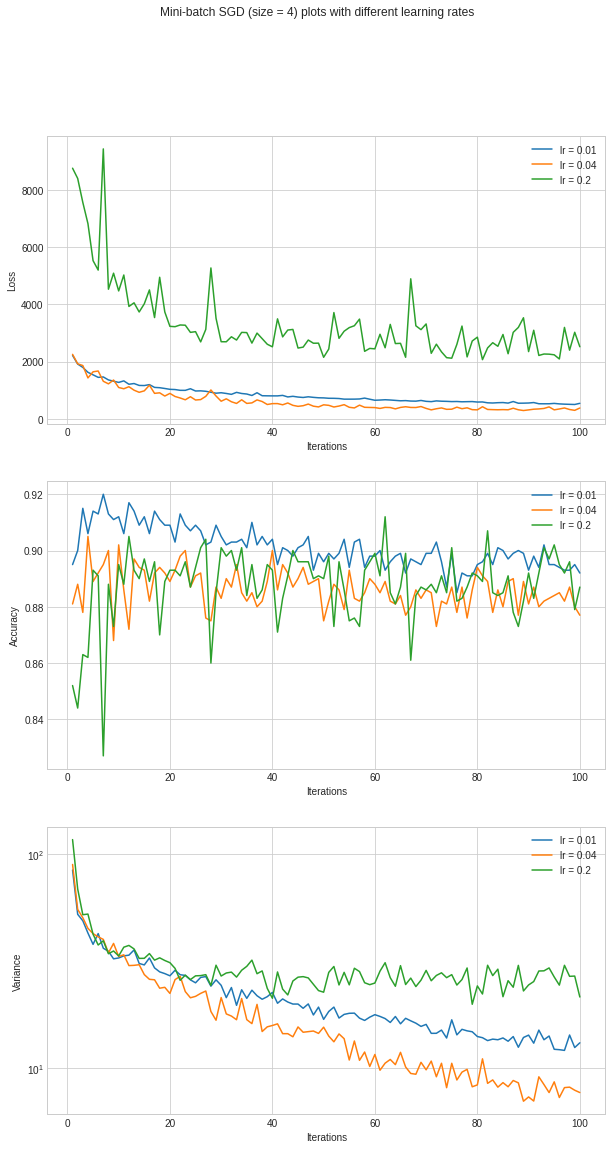

In [ ]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(3, figsize = (10, 18))
fig.suptitle('Mini-batch SGD (size = 4) plots with different learning rates')

axs[0].plot(range(1, 101), SGD4_losses01[1:], label='lr = 0.01')
axs[0].plot(range(1, 101), SGD4_losses04[1:], label='lr = 0.04')
axs[0].plot(range(1, 101), SGD4_losses2[1:], label='lr = 0.2')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Iterations')
axs[0].legend()

axs[1].plot(range(1, 101), SGD4_accs01[1:], label='lr = 0.01')
axs[1].plot(range(1, 101), SGD4_accs04[1:], label='lr = 0.04')
axs[1].plot(range(1, 101), SGD4_accs2[1:], label='lr = 0.2')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Iterations')
axs[1].legend()

axs[2].semilogy(range(1, 101), SGD4_vars01, label='lr = 0.01')
axs[2].semilogy(range(1, 101), SGD4_vars04, label='lr = 0.04')
axs[2].semilogy(range(1, 101), SGD4_vars2, label='lr = 0.2')
axs[2].set_ylabel('Variance')
axs[2].set_xlabel('Iterations')
axs[2].legend()

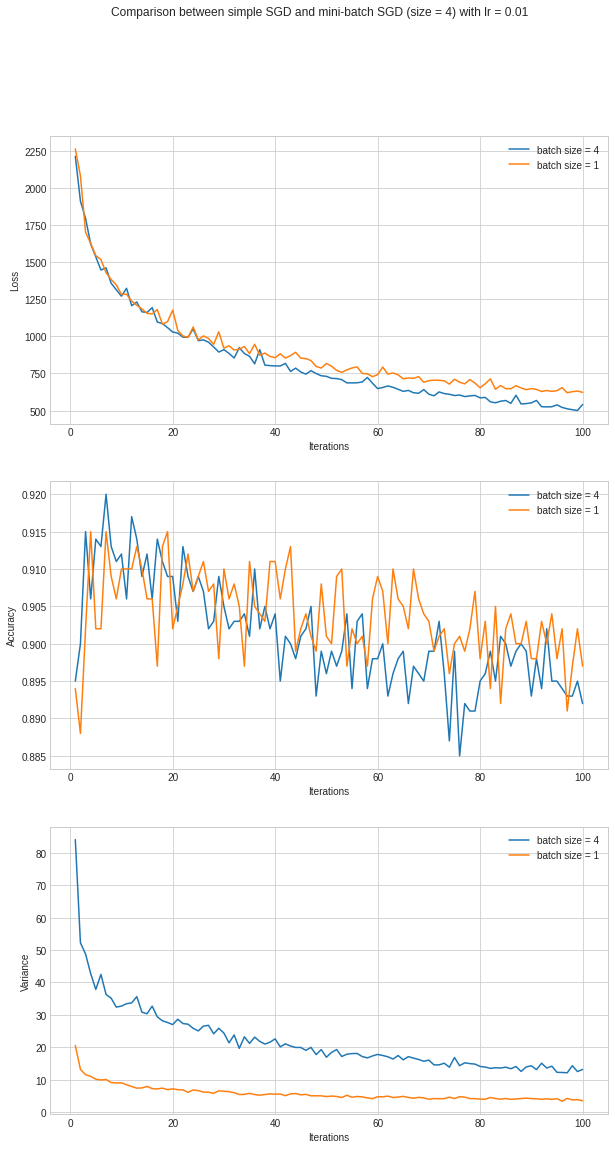

In [ ]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(3, figsize = (10, 18))
fig.suptitle('Comparison between simple SGD and mini-batch SGD (size = 4) with lr = 0.01')

axs[0].plot(range(1, 101), SGD4_losses01[1:], label='batch size = 4')
axs[0].plot(range(1, 101), SGD1_losses01[1:], label='batch size = 1')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Iterations')
axs[0].legend()

axs[1].plot(range(1, 101), SGD4_accs01[1:], label='batch size = 4')
axs[1].plot(range(1, 101), SGD1_accs01[1:], label='batch size = 1')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Iterations')
axs[1].legend()

axs[2].plot(range(1, 101), SGD4_vars01, label='batch size = 4')
axs[2].plot(range(1, 101), SGD1_vars01, label='batch size = 1')
axs[2].set_ylabel('Variance')
axs[2].set_xlabel('Iterations')
axs[2].legend()

### Problem 3

According to the paper, we know:

$$w_t = w_{t-1} - \eta_t \big(\nabla \psi_{i_t}(w_{t-1}) - \nabla \psi_{i_t}(\tilde{w}) + \nabla P(\tilde{w})\big),$$


where $\tilde{w}$ is a snapshot that is updated every $m$ iterations, $\eta_t$ is the learning rate, $\psi_{i}(w) = \mathcal{L}(w, X_i, y_i)$ and $P(w) = \sum_{i=1}^M  \psi_{i}(w)$, and $i_t$ is randomly drawn from $\{1, 2, ..., M\}$.

Let $\tilde{\mu} := \nabla P(\tilde{w})$, then the expectation of $\tilde{\mu} - \nabla \psi_{i_t}(\tilde{w})$ is zero. Thus we have

$$ \mathbb{E}[w_t|w_{t-1}] = \mathbb{E}[w_{t-1}|w_{t-1}] - \eta_t \mathbb{E}[\nabla \psi_{i_t}(w_{t-1})] - \eta_t \mathbb{E}[\tilde{\mu} - \nabla \psi_{i_t}(\tilde{w})] = w_{t-1} - \eta_t \nabla P(w_{t-1}).$$


We know that SGD is unbiased estimate of the gradient of $P$ at each step:

$$ \mathbb{E}[\nabla \psi_{i_t}(w_{t-1})] = \nabla P(w_{t-1})$$


Since $\nabla \psi_{i_t}(\tilde{w}) - \nabla \psi_{i_t}(w_{t-1}) \approx \tilde{\mu} - \nabla P(w_{t-1})$, SVRG updating rule cancels the randomness induced by random sampling $i_t$. When both $\tilde{w}$ and $w_t$ converge to the same parameter $w_∗$, then $\tilde{\mu} \rightarrow 0$ and $\nabla \psi_{i_t}(\tilde{w}) \rightarrow \nabla \psi_{i_t}(w_*)$. Therefore


$$
\nabla \psi_{i_t}(w_{t-1}) - \nabla \psi_{i_t}(\tilde{w}) + \tilde{\mu} \rightarrow \nabla \psi_{i_t}(w_{t-1}) - \nabla \psi_{i_t}(w_\ast) \rightarrow 0.
$$

This convergance to zero means variability is reduced.


We expect that when a high learning rate is used in SGD, in the beginning, training loss drops quickly, though it oscillates above the optima and never reaches it. With a small learning rate, the minimum may be approached eventually, but it will take many iterations. Thus, we need to start SGD with a large learning rate and gradually reduce it. By contrast, the learning rate for SVRG does not have to decay, and SVRG smoothly goes down faster than SGD, with relatively considerable less variance.


### Problem 4

In [ ]:
def compute_gradients(model, gamma):
    g_W, g_b = [], []
    for i in range(len(y_train)):
        grads0, grads1 = model.gradients(X_train[i:i+1], y_train[i:i+1], gamma)
        g_W.append(grads0.numpy())
        g_b.append(grads1.numpy())

    g_W = np.stack(g_W, axis = 0)
    g_b = np.stack(g_b, axis = 0)
    return g_W, g_b, np.mean(g_W, 0), np.mean(g_b, 0)

In [ ]:
def SVRG_optimize(lambd, m):   
    model = MNIST_Model()
    gamma = 1e-4
    optimizer = SGD(lambd)
    losses = [model.loss(X_train, y_train, gamma)]
    accs = [model.accuracy(X_test, y_test)]
    vars = []
    deltas = []

    print('Step 0: loss=', losses[-1].numpy(), ', accuracy=', accs[-1].numpy())

    for s in range(100):
        g_W, g_b, mu_W, mu_b = compute_gradients(model, gamma)

        for t in range(m):
            i = np.random.choice(M, 1)
            delta = model.SVRG(X_train[i], y_train[i], gamma, g_W[i[0]], g_b[i[0]], mu_W, mu_b, optimizer)
            deltas.append(delta)

        losses.append(model.loss(X_train, y_train, gamma))
        accs.append(model.accuracy(X_test, y_test))
        vars.append(compute_variance(deltas))
        deltas = []

        print('Step {0}: loss= {1:0.3f}, accuracy= {2:0.3f}, variance= {3:0.3f}'.format(
            s+1, losses[-1].numpy(), accs[-1].numpy(), vars[-1].numpy()))
    
    return losses, accs, vars

In [ ]:
SVRG_losses01, SVRG_accs01, SVRG_vars01 = SVRG_optimize(0.01, M)
SVRG_losses05, SVRG_accs05, SVRG_vars05 = SVRG_optimize(0.05, M)

Step 0: loss= 13815.89 , accuracy= 0.1
Step 1: loss= 2408.154, accuracy= 0.884, variance= 48.644
Step 2: loss= 1809.885, accuracy= 0.918, variance= 1.917
Step 3: loss= 1617.896, accuracy= 0.919, variance= 0.216
Step 4: loss= 1509.615, accuracy= 0.920, variance= 0.052
Step 5: loss= 1431.341, accuracy= 0.917, variance= 0.019
Step 6: loss= 1369.128, accuracy= 0.917, variance= 0.010
Step 7: loss= 1317.852, accuracy= 0.918, variance= 0.006
Step 8: loss= 1273.705, accuracy= 0.915, variance= 0.005
Step 9: loss= 1235.374, accuracy= 0.915, variance= 0.003
Step 10: loss= 1201.171, accuracy= 0.917, variance= 0.004
Step 11: loss= 1170.558, accuracy= 0.916, variance= 0.002
Step 12: loss= 1142.830, accuracy= 0.915, variance= 0.001
Step 13: loss= 1117.514, accuracy= 0.915, variance= 0.001
Step 14: loss= 1094.175, accuracy= 0.914, variance= 0.001
Step 15: loss= 1072.596, accuracy= 0.914, variance= 0.001
Step 16: loss= 1052.544, accuracy= 0.914, variance= 0.001
Step 17: loss= 1033.792, accuracy= 0.915,

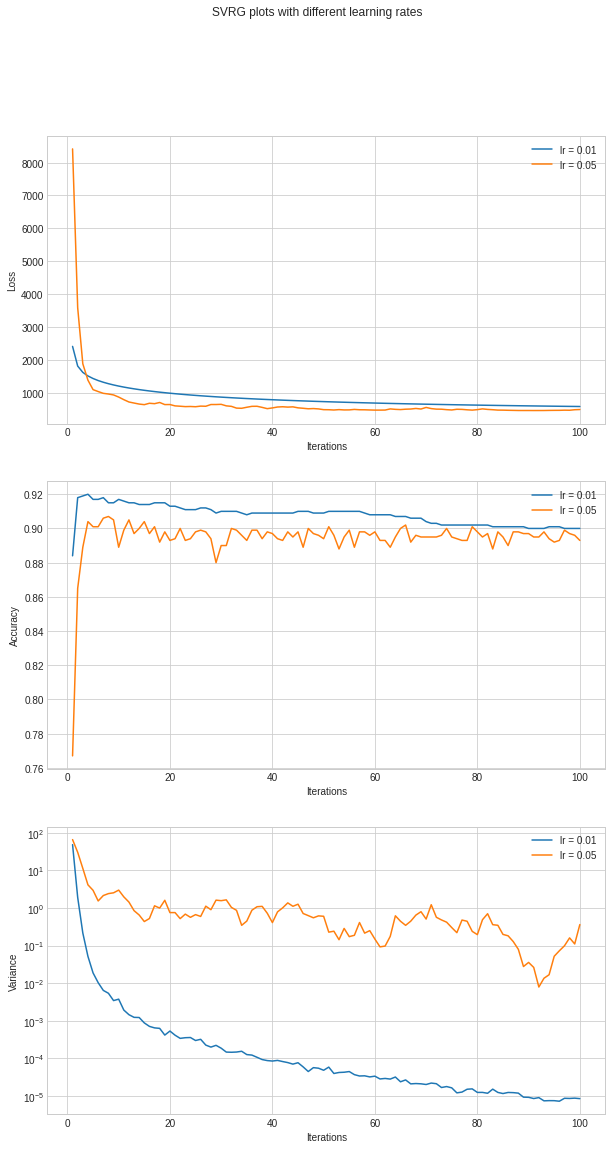

In [ ]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(3, figsize = (10, 18))
fig.suptitle('SVRG plots with different learning rates')

axs[0].plot(range(1, 101), SVRG_losses01[1:], label='lr = 0.01')
axs[0].plot(range(1, 101), SVRG_losses05[1:], label='lr = 0.05')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Iterations')
axs[0].legend()

axs[1].plot(range(1, 101), SVRG_accs01[1:], label='lr = 0.01')
axs[1].plot(range(1, 101), SVRG_accs05[1:], label='lr = 0.05')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Iterations')
axs[1].legend()

axs[2].semilogy(range(1, 101), SVRG_vars01, label='lr = 0.01')
axs[2].semilogy(range(1, 101), SVRG_vars05, label='lr = 0.05')
axs[2].set_ylabel('Variance')
axs[2].set_xlabel('Iterations')
axs[2].legend()

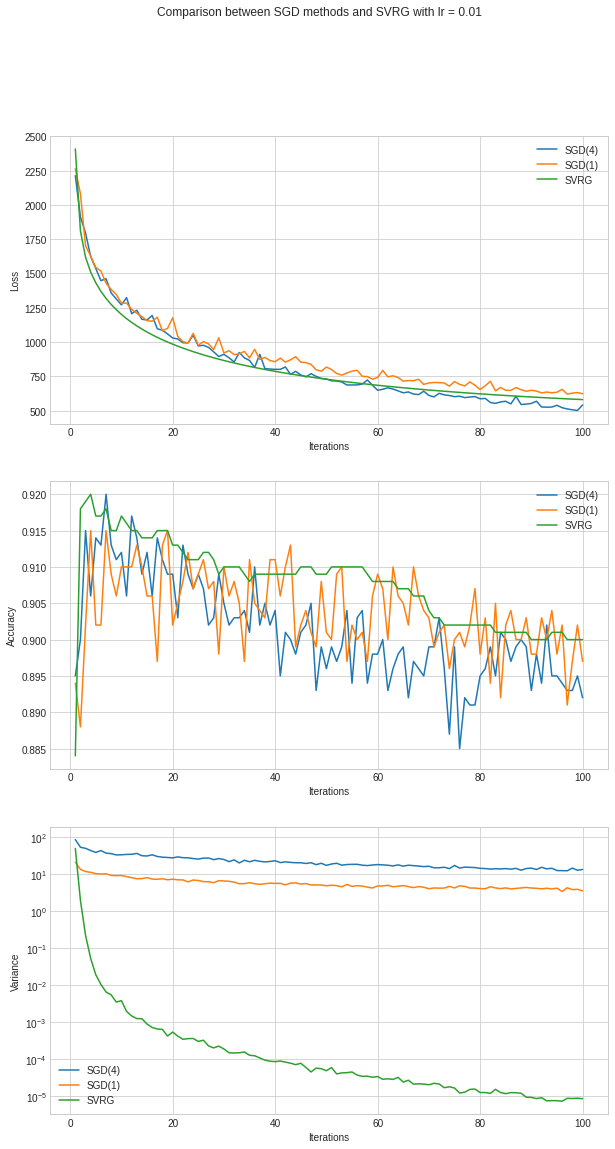

In [ ]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(3, figsize = (10, 18))
fig.suptitle('Comparison between SGD methods and SVRG with lr = 0.01')

axs[0].plot(range(1, 101), SGD4_losses01[1:], label='SGD(4)')
axs[0].plot(range(1, 101), SGD1_losses01[1:], label='SGD(1)')
axs[0].plot(range(1, 101), SVRG_losses01[1:], label='SVRG')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Iterations')
axs[0].legend()

axs[1].plot(range(1, 101), SGD4_accs01[1:], label='SGD(4)')
axs[1].plot(range(1, 101), SGD1_accs01[1:], label='SGD(1)')
axs[1].plot(range(1, 101), SVRG_accs01[1:], label='SVRG')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Iterations')
axs[1].legend()

axs[2].semilogy(range(1, 101), SGD4_vars01, label='SGD(4)')
axs[2].semilogy(range(1, 101), SGD1_vars01, label='SGD(1)')
axs[2].semilogy(range(1, 101), SVRG_vars01, label='SVRG')
axs[2].set_ylabel('Variance')
axs[2].set_xlabel('Iterations')
axs[2].legend()

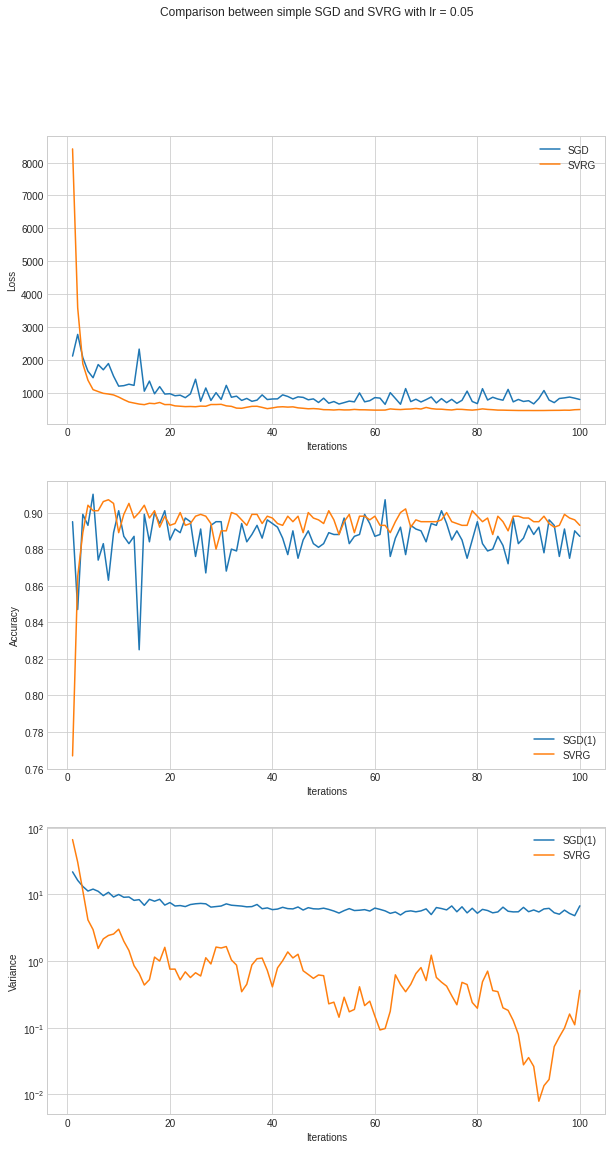

In [ ]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(3, figsize = (10, 18))
fig.suptitle('Comparison between simple SGD and SVRG with lr = 0.05')

axs[0].plot(range(1, 101), SGD1_losses05[1:], label='SGD')
axs[0].plot(range(1, 101), SVRG_losses05[1:], label='SVRG')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Iterations')
axs[0].legend()

axs[1].plot(range(1, 101), SGD1_accs05[1:], label='SGD(1)')
axs[1].plot(range(1, 101), SVRG_accs05[1:], label='SVRG')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Iterations')
axs[1].legend()

axs[2].semilogy(range(1, 101), SGD1_vars05, label='SGD(1)')
axs[2].semilogy(range(1, 101), SVRG_vars05, label='SVRG')
axs[2].set_ylabel('Variance')
axs[2].set_xlabel('Iterations')
axs[2].legend()

### Problem 5

**Pros:**


Reducing the stochastic gradient variance enables us to use a constant learning rate and obtains linear convergence in expectation. This is in contrast with SGD, which its randomness causes the gradient variance, leading to decay learning rate and sub-linear convergence rate.

This variance reduction method also applies to nonconvex optimization problems, such as training deep neural networks.

**Cons:**


In SVRG, the average number of gradient calculations per iteration increases (because of computing $\nabla P(\tilde{w})$). This could be computationally expensive when $M$ is large and significantly raises the average time of every step.



### Problem 6

By decreasing $m$, the number of stages for convergence increases, so we need to compute $\nabla P(\tilde{w})$ more frequently, leading to the more average time taken per iteration. However, for relatively large $m$, there would be bigger gaps between $\tilde{w}$ and $w$, which could reduce the algorithm's effect on variance reduction. Since every stage requires $2m + M$ gradient computations, it is natural to choose $m$ to be the same order of $M$.